![logo](1_bDwEvCRgrKVbLrAXEixpfA.png)
___

##### import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline 
sns.set(color_codes=True)

import functools as ft

#natural language processing
#pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vlad_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 3 - Outliers & NLP
    a) Importing data
    
    b) Success-percentage column
        - check for outliers
        
    c) Checking for other outliers
        i) goals
       ii) converted_pledged_cmount
      iii) backers_count
        
    d) Natural Language Processing
        - cleaning blurb variable
            - punctuation
            - stopwords
            - lemmatization
        - writing and saving corpus

### a) Importing data
##### Use 'cleaned_data.csv' to begin cleaning

In [17]:
#import .csv file
cleaned_df = pd.read_csv("cleaned_data.csv")

cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(cleaned_df.shape)
cleaned_df.head(1)

(149563, 21)


,id,name,genre,subgenre,category,source_url,blurb,slug,goal,converted_pledged_amount,...,launched_at,deadline,country,currency,backers_count,disable_communication,is_starrable,spotlight,staff_pick,state
0,498799566,"Strange Wit, an original graphic novel about J...",Graphic Novels,comics,"{""id"":252,""name"":""Graphic Novels"",""slug"":""comi...",https://www.kickstarter.com/discover/categorie...,"The true biography of the historical figure, w...",strange-wit-an-original-graphic-novel-about-ja...,12000,14740,...,2015-08-15 04:19:27,2015-09-14 04:19:27,US,USD,403,0,0,1,1,successful


##### Counts for 'state' column

In [18]:
print(cleaned_df['state'].value_counts())

successful    93849
failed        55714
Name: state, dtype: int64


In our data, we have a good proportion of failed:successful campaigns so the steps below will explore these numbers in more detail in an attempt to filter our data. After countless iterations, I have decided that the most optimum range of outliers to remove are the bottom and top 5%. By creating the following success-percentage column, I will show this outlier removal and subsequent filtering as well as look at the other quantitative columns and their potential outliers.

### b) Success-Percentage Column
Make a new column for success % (pledged amount / goal amount)

In [19]:
#create column
cleaned_df['success_percentage']=(cleaned_df['converted_pledged_amount'] / cleaned_df['goal']) * 100

In [20]:
#finding the missing and infinite values
print('null:', cleaned_df['success_percentage'].isnull().sum())
print('na:', cleaned_df['success_percentage'].isna().sum())
print('\n')
print('inf:', np.isinf(cleaned_df["success_percentage"]).value_counts())

null: 0
na: 0


inf: False    149562
True          1
Name: success_percentage, dtype: int64


In [21]:
#locate the row in which the inf value is present (last column == 'inf')
print(cleaned_df.index[np.isinf(cleaned_df['success_percentage'])])
print('\n')
print('Row 118304 "success_percentage" value:', cleaned_df['success_percentage'].iloc[118304])

Int64Index([118304], dtype='int64')


Row 118304 "success_percentage" value: inf


In [22]:
#drop the row with inf value
cleaned_df.drop(cleaned_df.index[118304], inplace=True)

#reset index
cleaned_df.reset_index(drop=True,inplace=True)

## total number of rows and columns
print('dataframe shape: ', cleaned_df.shape)

dataframe shape:  (149562, 22)


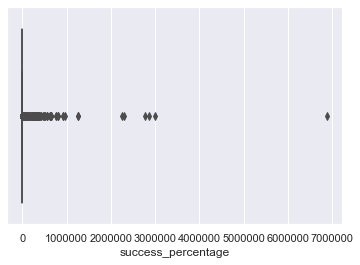

In [23]:
#make a boxplot of 'success_percentage' column
sns.boxplot(x=cleaned_df['success_percentage'])

In [24]:
#find 15% and 85% quartile values
a = cleaned_df.success_percentage.quantile(0.95)
b = cleaned_df.success_percentage.quantile(0.05)

#filter data based on quartile value
cleaned_df = cleaned_df[cleaned_df.success_percentage < a]
cleaned_df = cleaned_df[cleaned_df.success_percentage > b]

print('Length of dataframe:', len(cleaned_df['success_percentage']))

Length of dataframe: 131217


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF86F84C88>]],
      dtype=object)

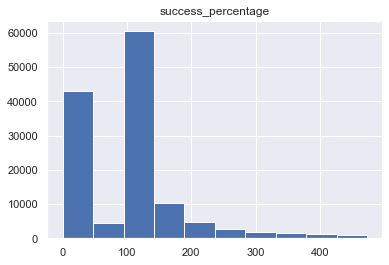

In [25]:
cleaned_df.hist(column='success_percentage')

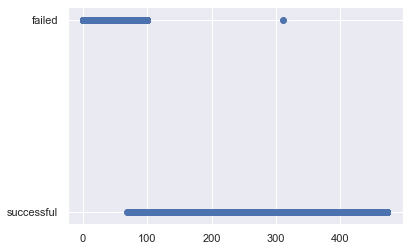

In [26]:
y = cleaned_df['state']
x = cleaned_df['success_percentage']

plt.scatter(x, y)
plt.show()

Our boxplot is starting to look more like a box now.


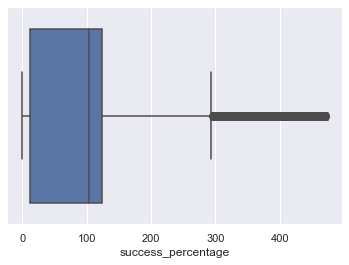

In [27]:
sns.boxplot(x=cleaned_df['success_percentage'])
print('Our boxplot is starting to look more like a box now.')

In [28]:
print(cleaned_df['state'].value_counts())

successful    86366
failed        44851
Name: state, dtype: int64


### c) Checking for other outliers

Since we already removed outliers from the success-percentage column, removing more outliers from either goal and converted_pledged_amount would be redudant. Therefore, I will only turn my attention to removing outliers from the remaining quantitative variable: backers_count

##### backers count

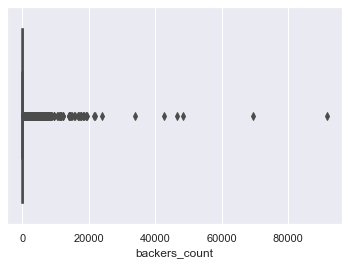

In [29]:
sns.boxplot(x=cleaned_df['backers_count'])

In [30]:
#find 10% and 90% quartile values
a = cleaned_df.backers_count.quantile(0.95)
b = cleaned_df.backers_count.quantile(0.05)

#filter data based on quartile value
cleaned_df = cleaned_df[cleaned_df.backers_count < a]
cleaned_df = cleaned_df[cleaned_df.backers_count > b]

print('Length of dataframe:', len(cleaned_df['backers_count']))

Length of dataframe: 114898


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF8793AAC8>]],
      dtype=object)

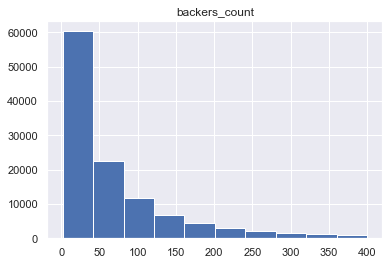

In [31]:
cleaned_df.hist(column='backers_count')

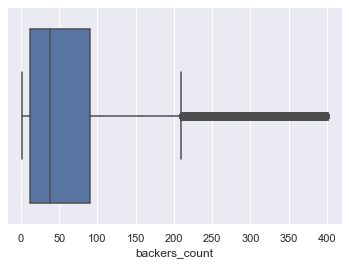

In [32]:
sns.boxplot(x=cleaned_df['backers_count'])

In [43]:
#check range of data
print(cleaned_df['state'].value_counts())

successful    79694
failed        35204
Name: state, dtype: int64


In [44]:
#reset index
cleaned_df.reset_index(drop=True,inplace=True)

### f) Natural Language Processing

##### Clean the first row to check

In [45]:
#create 'text' variable of every blurb description
text = pd.DataFrame(cleaned_df['blurb'])

#lets clean the first blurb as a first step
text['blurb'][0]

'Educating my community about self-sufficiency and building basics through constructing a tiny house.'

In [46]:
#only keep letters and replace other symbols with a white space in the first blurb
blurb = re.sub('[^a-zA-Z]', ' ', text['blurb'][0])

#change letters to lower-case
blurb = blurb.lower()   

#split the first blurb which is a string into list
blurb = blurb.split()

#for loop to remove stop-words and to do lemmatization
wn = WordNetLemmatizer()
blurb = [wn.lemmatize(word) for word in blurb if not word in set(stopwords.words('english'))]

#join blurb back into a string from a list
blurb = ' '.join(blurb)

blurb

'educating community self sufficiency building basic constructing tiny house'

### Clean the entire 'blurb' column

In [47]:
print(len(pd.DataFrame(cleaned_df['blurb'])))
length = len(pd.DataFrame(cleaned_df['blurb']))

114898


In [48]:
corpus = []
for i in range(0, length):
    #only keep letters and replace other symbols with a white space in the first blurb
    blurb = re.sub('[^a-zA-Z]', ' ', text['blurb'][i])

    #change letters to lower-case
    blurb = blurb.lower()   
    #split
    blurb = blurb.split()
    #for loop to remove stop-words and to do stemming
    wn = WordNetLemmatizer()
    blurb = [wn.lemmatize(word) for word in blurb if not word in set(stopwords.words('english'))]
    #join blurb back into a string from a list
    blurb = ' '.join(blurb)
    corpus.append(blurb)

In [49]:
#write corpus array into a dataframe and save it to a csv for importing into the Step 4 (Classification)
corpus_df = pd.DataFrame(corpus, columns = ['blurb'])
corpus_df.head()

,blurb
0,educating community self sufficiency building ...
1,rewarding thing event attend
2,thema literary society proposes publish one th...
3,cnc crafted billet aluminum unique sophisticat...
4,collection hand lettered thing say idea sentim...


### End of Step 3

In [50]:
#write corpus_df to a .csv
corpus_df.to_csv('corpus_data.csv')

In [51]:
#write cleaned cleaned_df to a .csv
cleaned_df.to_csv('cleaned2_data.csv')